## 批量规范化

批量规范化（batch normalization）是一种流行且有效的技术，可持续加速深层网络的收敛速度。结合残差块，批量规范化使得研究人员能够训练100层以上的网络。

### 训练深层网络

数据预处理的方式通常会对最终结果产生巨大影响。

使用真实数据时，第一步是标准化输入特征，使其平均值为0，方差为1。直观地说，这种标准化可以很好地与我们的优化器配合使用，因为它可以将参数的量级进行统一。

第二，对于典型的多层感知机或卷积神经网络。当我们训练时，中间层中的变量（例如，多层感知机中的仿射变换输出）可能具有更广的变化范围：不论是沿着从输入到输出的层，跨同一层中的单元，或是随着时间的推移，模型参数随着训练更新而变幻莫测。批量规范化的发明者非正式地假设，这些变量分布中的这种偏移可能会阻碍网络的收敛。直观地说，我们可能会猜想，如果一个层的可变值是另一层的100倍，这可能需要对学习率进行补偿调整。

第三，更深层的网络很复杂，容易过拟合，这意味着正则化变得更加重要。

批量规范化应用于单个可选层（也可以应用到所有层），其原理如下：

在每次训练迭代中，首先规范化输入，即通过减去其均值并除以其标准差，其中两者均基于当前小批量处理。接下来，应用比例系数和比例偏移。

正是由于这个基于批量统计的标准化，才有了批量规范化的名称。

从形式上来说，用$\mathbf{x} \in \mathcal{B}$表示一个来自小批量$\mathcal{B}$的输入，批量规范化$\mathrm{BN}$根据以下表达式转换$\mathbf{x}$：

$$\mathrm{BN}(\mathbf{x}) = \boldsymbol{\gamma} \odot \frac{\mathbf{x} - \hat{\boldsymbol{\mu}}_\mathcal{B}}{\hat{\boldsymbol{\sigma}}_\mathcal{B}} + \boldsymbol{\beta}.$$

$\hat{\boldsymbol{\mu}}_\mathcal{B}$是小批量$\mathcal{B}$的样本均值，$\hat{\boldsymbol{\sigma}}_\mathcal{B}$是小批量$\mathcal{B}$的样本标准差。

应用标准化后，生成的小批量的平均值为0和单位方差为1。

由于单位方差（与其他一些魔法数）是一个主观的选择，因此我们通常包含
拉伸参数（scale）$\boldsymbol{\gamma}$和偏移参数（shift）$\boldsymbol{\beta}$，它们的形状与$\mathbf{x}$相同。
请注意，$\boldsymbol{\gamma}$和$\boldsymbol{\beta}$是需要与其他模型参数一起学习的参数。

由于在训练过程中，中间层的变化幅度不能过于剧烈，而批量规范化将每一层主动居中，并将它们重新调整为给定的平均值和大小（通过$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$）。

从形式上来看，我们计算出$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$，如下所示：

$$\begin{aligned} \hat{\boldsymbol{\mu}}_\mathcal{B} &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} \mathbf{x},\\
\hat{\boldsymbol{\sigma}}_\mathcal{B}^2 &= \frac{1}{|\mathcal{B}|} \sum_{\mathbf{x} \in \mathcal{B}} (\mathbf{x} - \hat{\boldsymbol{\mu}}_{\mathcal{B}})^2 + \epsilon.\end{aligned}$$

我们在方差估计值中添加一个小的常量$\epsilon > 0$，以确保我们永远不会尝试除以零，即使在经验方差估计值可能消失的情况下也是如此。估计值$\hat{\boldsymbol{\mu}}_\mathcal{B}$和${\hat{\boldsymbol{\sigma}}_\mathcal{B}}$通过使用平均值和方差的噪声（noise）估计来抵消缩放问题。

批量规范化层在“训练模式”（通过小批量统计数据规范化）和“预测模式”（通过数据集统计规范化）中的功能不同。

在训练过程中，我们无法得知使用整个数据集来估计平均值和方差，所以只能根据每个小批次的平均值和方差不断训练模型。

在预测模式下，可以根据整个数据集精确计算批量规范化所需的平均值和方差。

## 批量规范化层

批量规范化层和其他层之间的关键区别是，由于批量规范化在完整的小批量上运行，因此不能像在引入其他层时那样忽略批量大小。

下面讨论批量规范化在全连接层和卷积层的实现。

### 全连接层

通常，将批量规范化层置于全连接层中的仿射变换和激活函数之间。

设全连接层的输入为x，权重参数和偏置参数分别为$\mathbf{W}$和$\mathbf{b}$，激活函数为$\phi$，批量规范化的运算符为$\mathrm{BN}$。

使用批量规范化的全连接层的输出的计算详情如下：

$$\mathbf{h} = \phi(\mathrm{BN}(\mathbf{W}\mathbf{x} + \mathbf{b}) ).$$

### 卷积层

对于卷积层，可以在卷积层之后和非线性激活函数之前应用批量规范化。

当卷积有多个输出通道时，需要对这些通道的“每个”输出执行批量规范化，每个通道都有自己的拉伸（scale）和偏移（shift）参数，这两个参数都是标量。

假设小批量包含$m$个样本，并且对于每个通道，卷积的输出具有高度$p$和宽度$q$。
那么对于卷积层，在每个输出通道的$m \cdot p \cdot q$个元素上同时执行每个批量规范化。

因此，在计算平均值和方差时，会收集所有空间位置的值，然后在给定通道内应用相同的均值和方差，以便在每个空间位置对值进行规范化。

### 预测过程中的批量规范化

批量规范化在训练模式和预测模式下的行为通常不同。

首先，将训练好的模型用于预测时，不再需要样本均值中的噪声以及在微批次上估计每个小批次产生的样本方差。

其次，可能需要使用模型对逐个样本进行预测。

一种常用的方法是通过移动平均估算整个训练数据集的样本均值和方差，并在预测时使用它们得到确定的输出。

可见，和暂退法一样，批量规范化层在训练模式和预测模式下的计算结果也是不同的。

## 从零实现

从头开始实现一个具有张量的批量规范化层。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l


def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

现在可以创建一个正确的BatchNorm层，这个层将保持适当的参数：拉伸gamma和偏移beta，这两个参数将在训练过程中更新。此外，我们的层将保持均值和方差的移动平均值，以便在模型预测期间随后使用。

In [2]:
class BatchNorm(nn.Module):
    # num_features：完全连接层的输出数量或卷积层的输出通道数。
    # num_dims：2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

## 使用批量规范化层的LeNet

将批量规范化层应用于LeNet模型。

批量规范化是在卷积层或全连接层之后、相应的激活函数之前应用的。

In [3]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

在Fashion-MNIST数据集上训练网络。

loss 0.275, train acc 0.898, test acc 0.874
4387.5 examples/sec on cpu


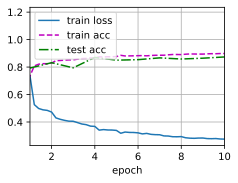

In [5]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

在第一个批量规范化层中学到的拉伸参数gamma和偏移参数beta。

In [6]:
net[1].gamma.reshape((-1,)), net[1].beta.reshape((-1,))

(tensor([0.4557, 4.1285, 1.3258, 3.2266, 0.7758, 2.6093],
        grad_fn=<ViewBackward0>),
 tensor([ 1.0967, -2.4698,  0.1223,  3.5971, -1.6486,  2.3493],
        grad_fn=<ViewBackward0>))

## 简明实现

直接使用深度学习框架中定义的BatchNorm。

In [7]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

使用相同超参数来训练模型。

loss 0.261, train acc 0.904, test acc 0.826
5595.5 examples/sec on cpu


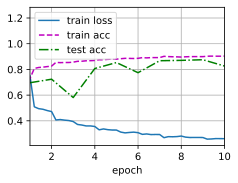

In [9]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

通常高级API变体运行速度快很多，因为它的代码已经编译为C++或CUDA，而我们的自定义代码由Python实现。